## Import Library

- tensorflow 2.x(tf.keras)
- pandas
- numpy
- datetime
- matplotlib.pyplot
- google.colab
- os

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


## Google Colab Mount

- account : leeyeoreum01@gmail.com

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Google Colab Working Directory Select

- csv file dir = 'tensorflow_2.x_working_dir'
- ipynb file dir = 'Colab Notebooks'

In [3]:
import os

working_dir = 'tensorflow_2.x_working_dir'

colab_default_dir = '/content/gdrive/My Drive/Colab Notebooks/'

original_dir = os.getcwd()

try:

    os.chdir(colab_default_dir)

    if not os.path.exists(working_dir):
        os.mkdir(working_dir)

    os.chdir(working_dir)
    print('current_dir = ', os.getcwd())

except Exception as err:

    os.chdir(original_dir)
    print(str(err))

current_dir =  /content/gdrive/My Drive/Colab Notebooks/tensorflow_2.x_working_dir


## File Upload

- digit_train.csv
- digit_test.csv

In [4]:
try:

    original_train_df = pd.read_csv('digit_train.csv')
    original_test_df = pd.read_csv('digit_test.csv')

    print('type(original_train_df) = ', type(original_train_df))
    print('original_train_df.shape = ', original_train_df.shape)
    print()
    print('type(original_test_df) = ', type(original_test_df))
    print('original_test_df.shape = ', original_test_df.shape)
    
except Exception as err:
    
    print(str(err))

type(original_train_df) =  <class 'pandas.core.frame.DataFrame'>
original_train_df.shape =  (42000, 785)

type(original_test_df) =  <class 'pandas.core.frame.DataFrame'>
original_test_df.shape =  (28000, 784)


In [8]:
train_df = original_train_df.copy()
test_df = original_test_df.copy()

contaminated_data_set = {258, 1063, 1413, 1649, 1658, 1994, 5774, 20145, 20280, 
                         20693, 24689, 25460, 26630, 27137, 27206, 27211, 27230,
                         28168, 28274, 28380, 28997, 29258, 8078, 9460, 9895, 
                         18915, 9931, 26583, 8629, 25352, 17046, 10235, 19869, 
                         17637, 9375}
 # 중복 방지

print(contaminated_data_set)
print("type(contaminated_data_set) = ", type(contaminated_data_set))
print()
contaminated_data_list = list(contaminated_data_set)

train_df.drop(train_df.index[contaminated_data_list], inplace=True)

print('type(train_df) = ', type(train_df))
print('train_df.shape = ', train_df.shape)
print()
print('type(test_df) = ', type(test_df))
print('test_df.shape = ', test_df.shape)

{27137, 26630, 28168, 25352, 5774, 8078, 17046, 19869, 9375, 9895, 20145, 8629, 20280, 28997, 27206, 29258, 27211, 9931, 20693, 26583, 28380, 27230, 18915, 17637, 1649, 24689, 28274, 25460, 9460, 10235}
type(contaminated_data_set) =  <class 'set'>

type(train_df) =  <class 'pandas.core.frame.DataFrame'>
train_df.shape =  (41970, 785)

type(test_df) =  <class 'pandas.core.frame.DataFrame'>
test_df.shape =  (28000, 784)


## Data Generation

- train data : 70%
- test data : 30%

- Normalization (+ test data (<- test df)): True

In [9]:
class DataGeneration:
    
    # target_position = 0 (첫번째열이 정답데이터), target_position=-1 (마지막열이 정답데이터)
    def __init__(self, file, seperation_rate, target_position=-1):
        
        self.file = file
        
        self.seperation_rate = seperation_rate
        
        if (target_position == -1  or  target_position == 0):      
            self.target_position = target_position
        
        else:
            err_str = 'target_position must be -1 or 0'            
            raise Exception(err_str)    
            
    
    # print data target distribution 
    # str_of_kind : 'original data' or  'training data'  or  'test data'
    def __display_target_distribution(self, data, str_of_kind='original data'):
        
        print('=======================================================================================================')
        
        target_data = data[ :, self.target_position ]
        
        # numpy.unique() 사용하여 loaded data target 분포 확인
        unique, counts = np.unique(target_data, return_counts=True)

        unique_target = []
    
        for index in range(len(unique)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique[index], ', count = ', counts[index])
        
            unique_target.append(unique[index])

        for index in range(len(unique_target)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique_target[index], ', ratio = ', np.round(100 * counts[index] / (target_data.shape[0]), 2), ' %')
    
        print('=======================================================================================================')
        
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        loaded_data = self.file

        print("[DataGeneration]  loaded_data.shape = ", loaded_data.shape)
            
        # print the target distribution of original data 
        
        self.__display_target_distribution(loaded_data, 'original data')
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        # display target distribution of generated data 
        
        self.__display_target_distribution(training_data, 'training data')
        
        self.__display_target_distribution(test_data, 'test data')
        
        return training_data, test_data

In [10]:
# DataGeneration class 이용하여 training data , validation data, test data 생성

train_data = np.array(train_df) # 학습 데이터프레임

data_obj = DataGeneration(train_data, seperation_rate=0.3, target_position=0)
(train_train_data, train_test_data) = data_obj.generate()

test_data = np.array(test_df) # 예측 데이터프레임

print("train_data.shape = ", train_data.shape,
      ", train_data.ndim = ", train_data.ndim)
print("train_train_data.shape = ", train_train_data.shape, 
      ", train_test_data.shape = ", train_test_data.shape)
print("test_data.shape = ", test_data.shape,
      ", test_data.ndim = ", test_data.ndim)

[DataGeneration]  loaded_data.shape =  (41970, 785)
[DataGeneration] unique number of original data =  0 , count =  4124
[DataGeneration] unique number of original data =  1 , count =  4680
[DataGeneration] unique number of original data =  2 , count =  4176
[DataGeneration] unique number of original data =  3 , count =  4349
[DataGeneration] unique number of original data =  4 , count =  4070
[DataGeneration] unique number of original data =  5 , count =  3791
[DataGeneration] unique number of original data =  6 , count =  4134
[DataGeneration] unique number of original data =  7 , count =  4399
[DataGeneration] unique number of original data =  8 , count =  4061
[DataGeneration] unique number of original data =  9 , count =  4186
[DataGeneration] unique number of original data =  0 , ratio =  9.83  %
[DataGeneration] unique number of original data =  1 , ratio =  11.15  %
[DataGeneration] unique number of original data =  2 , ratio =  9.95  %
[DataGeneration] unique number of origina

In [11]:
train_train_xdata = train_train_data[ :  , 1:]
train_train_tdata = train_train_data[ :  , [0]]

train_test_xdata = train_test_data[ :  , 1:]
train_test_tdata = train_test_data[ :  , [0]]

print("train_train_xdata = ", train_train_xdata.shape, 
      ", train_train_tdata = ", train_train_tdata.shape)
print("train_test_xdata = ", train_test_xdata.shape, 
      ", train_test_tdata = ", train_test_tdata.shape)

train_train_xdata =  (29379, 784) , train_train_tdata =  (29379, 1)
train_test_xdata =  (12591, 784) , train_test_tdata =  (12591, 1)


In [12]:
# 정규화(Normalization) 코드

def data_normalization(data):
  
    try:

        if data.ndim != 2:
            raise Exception("Warning: input data must be 2 dim!!")

        data = (data - np.min(data)) / (np.max(data) - np.min(data))

        return data

    except Exception as err:
        raise Exception

try:
    data_normalization(train_train_xdata)
    data_normalization(train_test_xdata)
    data_normalization(test_data)

except Exception as err:
    print(str(err))


In [13]:
print('max(train_train_xdata) = ', np.max(train_train_xdata))
print('min(train_train_xdata) = ', np.min(train_train_xdata))

max(train_train_xdata) =  255
min(train_train_xdata) =  0


In [14]:
print('max(train_test_xdata) = ', np.max(train_test_xdata))
print('min(train_test_xdata) = ', np.min(train_test_xdata))

max(train_test_xdata) =  255
min(train_test_xdata) =  0


In [15]:
print('max(test_data) = ', np.max(test_data))
print('min(test_data) = ', np.min(test_data))

max(test_data) =  255
min(test_data) =  0


## Get Dataframe

- function of getting dataframe before encoding csv

In [16]:
def get_dataframe(result):

    if result.ndim != 1:
        result = result.reshape(-1) # changing data shape to 1 dim in order to get df

    df = pd.DataFrame({
        'ImageId': np.array(range(1, (len(result)+1))),
        'Label': result
        })

    return df

## Beta Model

In [17]:
model = Sequential()

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=32,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=64,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=128,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=256,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=512,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))


model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=1024,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

In [18]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 512)         1

In [19]:
start_time = datetime.now()

hist = model.fit(train_train_xdata.reshape(-1, 28, 28, 1), train_train_tdata,
                 batch_size=50, epochs=50, validation_split=0.1)

end_time = datetime.now()

print('\nElasped time : ', end_time - start_time)

Epoch 1/50
529/529 [==============================] - 8s 16ms/step - loss: 0.5439 - accuracy: 0.9039 - val_loss: 0.0708 - val_accuracy: 0.9809
Epoch 2/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0625 - accuracy: 0.9810 - val_loss: 0.0888 - val_accuracy: 0.9765
Epoch 3/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0454 - accuracy: 0.9863 - val_loss: 0.0544 - val_accuracy: 0.9830
Epoch 4/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0405 - accuracy: 0.9874 - val_loss: 0.0680 - val_accuracy: 0.9823
Epoch 5/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0272 - accuracy: 0.9919 - val_loss: 0.0609 - val_accuracy: 0.9857
Epoch 6/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0347 - accuracy: 0.9893 - val_loss: 0.0470 - val_accuracy: 0.9881
Epoch 7/50
529/529 [==============================] - 8s 15ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.0666 - val_accuracy: 0.9847

In [20]:
model.evaluate(train_test_xdata.reshape(-1, 28, 28, 1), train_test_tdata)

394/394 [==============================] - 2s 4ms/step - loss: 0.2326 - accuracy: 0.9840


[0.2326277792453766, 0.9839568138122559]

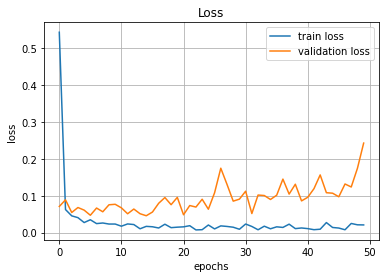

In [21]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')

plt.legend(loc='best')

plt.show()

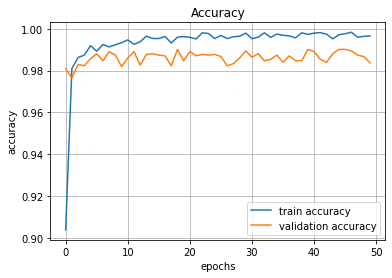

In [22]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')

plt.legend(loc='best')

plt.show()

In [23]:
real_predict_list = model.predict(train_train_xdata.reshape(-1, 28, 28, 1))

print('type(real_predict_list) = ', type(real_predict_list))
print()

logical_predict_list = np.argmax(real_predict_list, axis=1)

print("logical_predict_list sample = ", logical_predict_list[:10])
print()

label_list = train_train_tdata.flatten()

index_label_prediction_list = [[idx, label_list[idx], prediction] for idx, prediction in enumerate(logical_predict_list) if label_list[idx] != prediction]

print(index_label_prediction_list)

train_accuracy = 1 - (len(index_label_prediction_list) / len(label_list))

print('\ntrain accuracy = ', train_accuracy)

type(real_predict_list) =  <class 'numpy.ndarray'>

logical_predict_list sample =  [0 5 9 5 1 4 8 1 3 4]

[[80, 9, 4], [152, 9, 5], [258, 9, 4], [445, 2, 1], [526, 5, 4], [772, 1, 4], [1063, 8, 3], [1413, 0, 2], [1423, 9, 4], [1658, 9, 8], [1994, 9, 4], [2064, 9, 8], [2359, 9, 4], [2382, 2, 7], [2514, 9, 4], [2712, 9, 4], [2879, 9, 4], [3068, 6, 4], [3114, 9, 4], [3118, 9, 4], [3717, 2, 1], [3804, 9, 7], [3917, 3, 5], [4038, 9, 4], [4669, 3, 7], [5596, 2, 1], [5773, 3, 2], [5949, 2, 0], [6040, 9, 7], [6406, 9, 4], [6748, 2, 7], [6898, 2, 7], [7047, 9, 4], [7373, 9, 4], [7511, 3, 7], [7694, 2, 7], [7767, 8, 2], [7960, 9, 4], [7974, 9, 5], [8358, 2, 7], [8649, 2, 7], [8704, 9, 5], [8707, 3, 8], [8708, 9, 8], [8864, 2, 3], [9195, 9, 4], [9438, 9, 5], [9732, 9, 4], [9809, 9, 7], [10370, 3, 7], [10510, 9, 8], [10971, 9, 4], [11135, 9, 4], [11618, 9, 4], [11762, 9, 4], [12031, 2, 7], [12055, 9, 4], [12196, 2, 7], [12602, 9, 4], [12607, 9, 4], [13114, 9, 4], [13216, 9, 4], [13627, 9, 4], [137

len(index_label_prediction_list) =  166



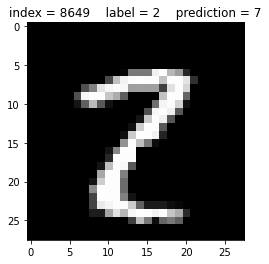

In [24]:
print("len(index_label_prediction_list) = ", len(index_label_prediction_list))
print()

random_pick_index = np.random.randint(len(index_label_prediction_list))

false_data_index = index_label_prediction_list[random_pick_index][0]
false_data_label = index_label_prediction_list[random_pick_index][1]
false_data_prediction = index_label_prediction_list[random_pick_index][2]

img = train_train_xdata[false_data_index].reshape(28, 28)

title = 'index = ' + str(false_data_index) + '    ' + 'label = ' + str(false_data_label) + '    ' + 'prediction = ' + str(false_data_prediction)

plt.title(title)
plt.imshow(img, cmap='gray')
plt.show()

len(index_label_prediction_list) =  166

start index : 0
count : 166


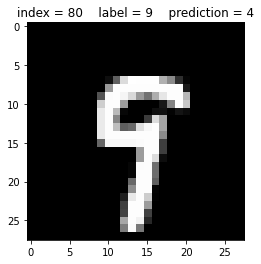

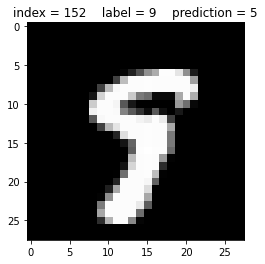

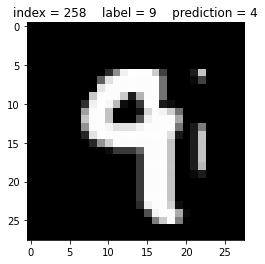

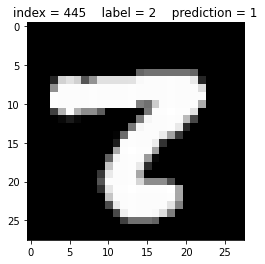

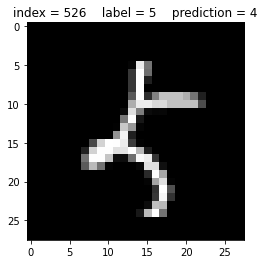

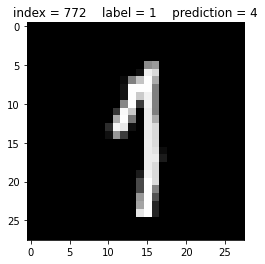

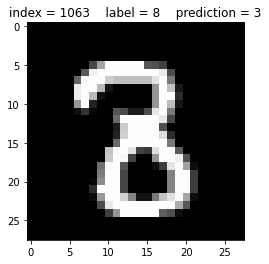

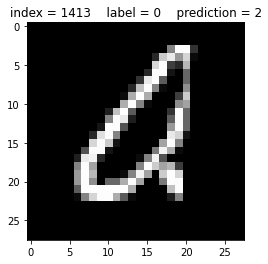

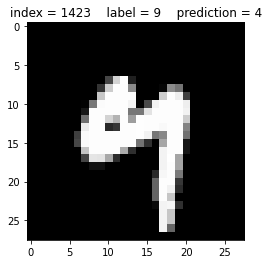

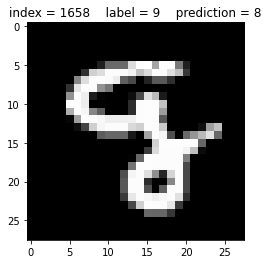

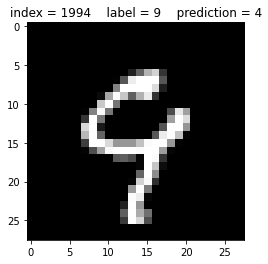

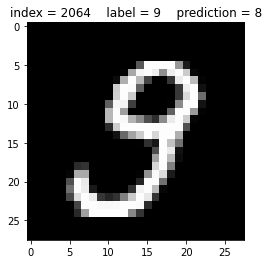

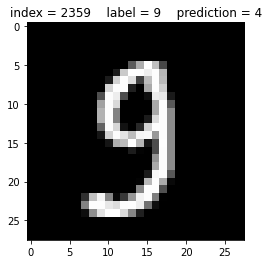

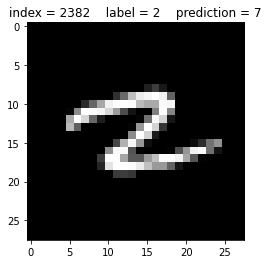

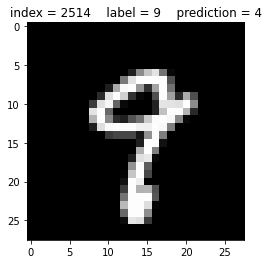

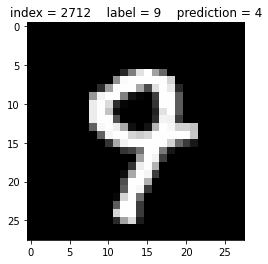

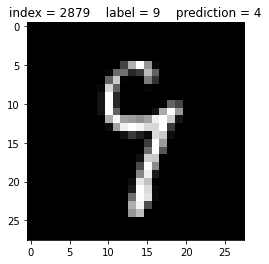

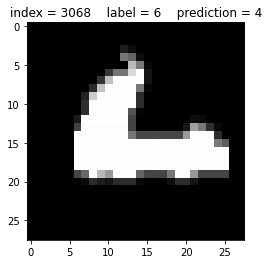

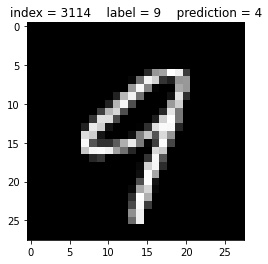

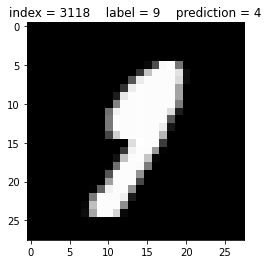

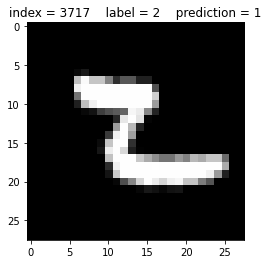

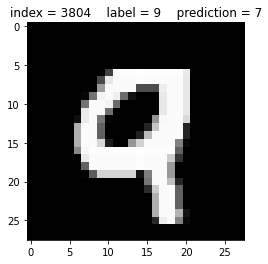

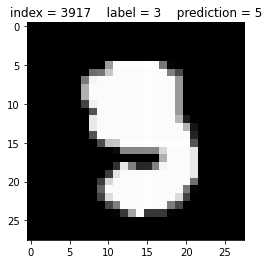

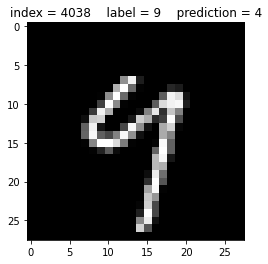

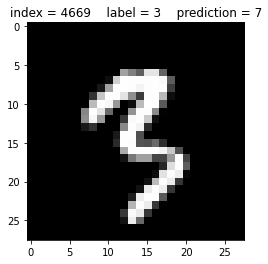

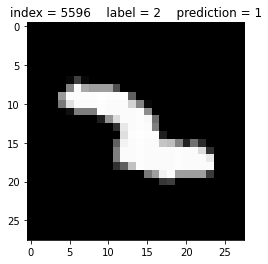

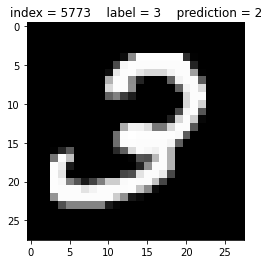

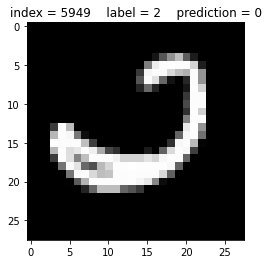

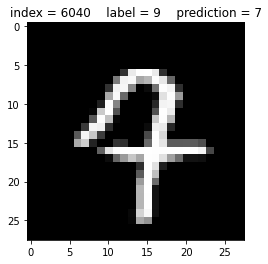

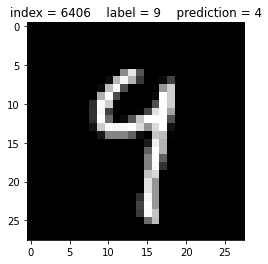

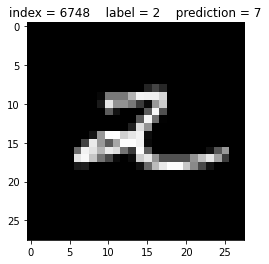

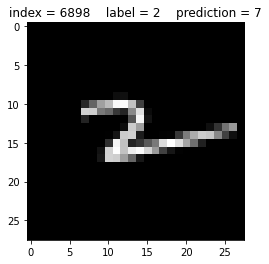

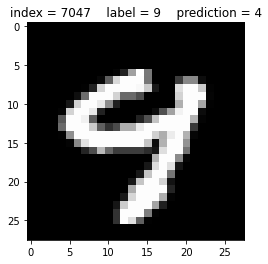

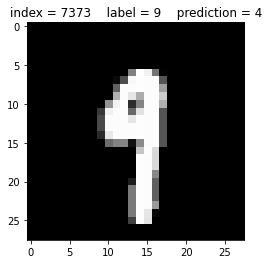

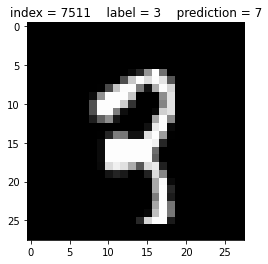

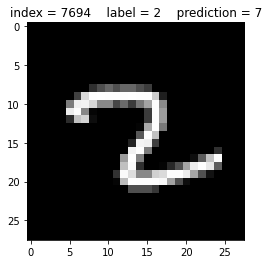

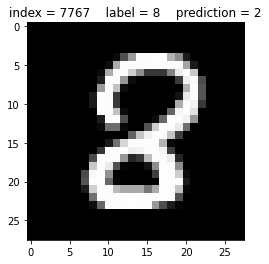

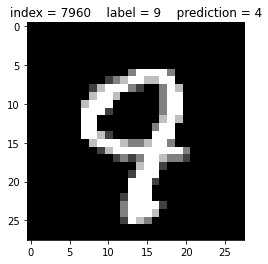

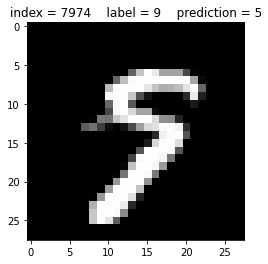

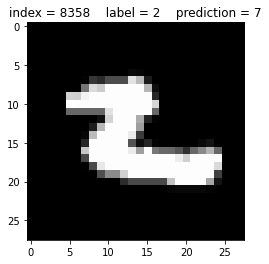

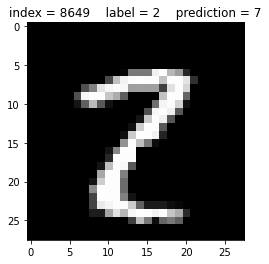

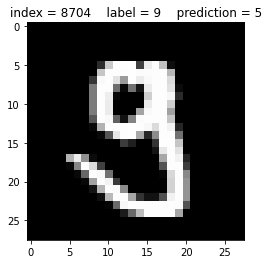

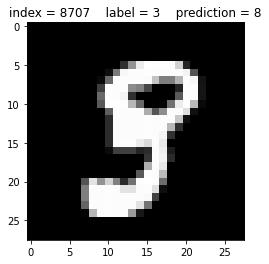

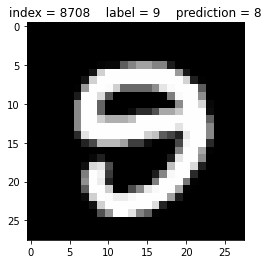

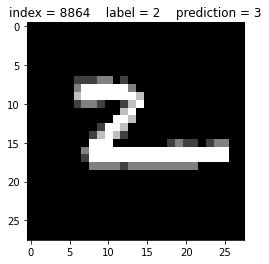

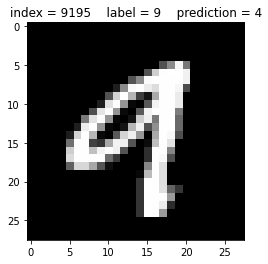

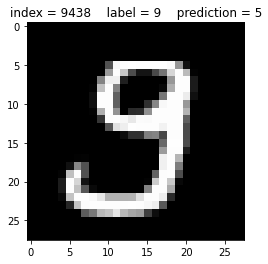

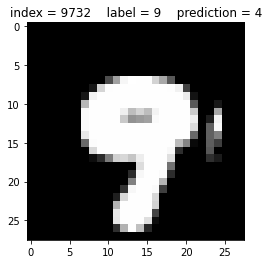

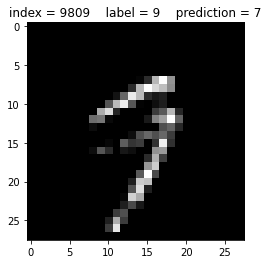

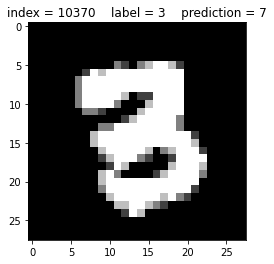

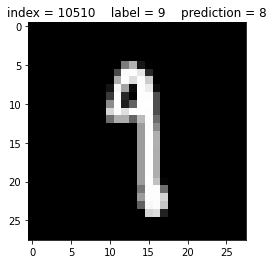

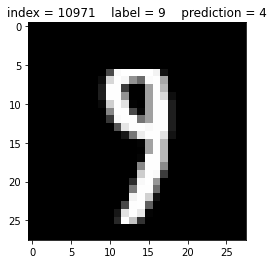

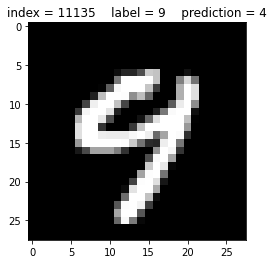

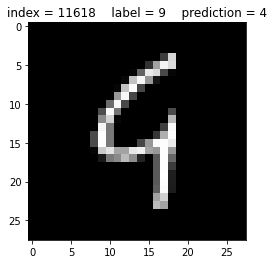

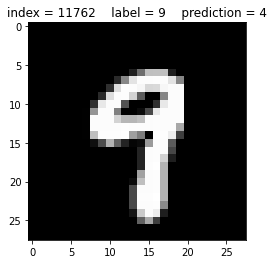

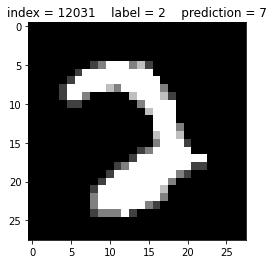

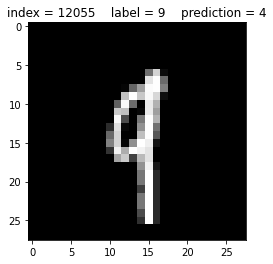

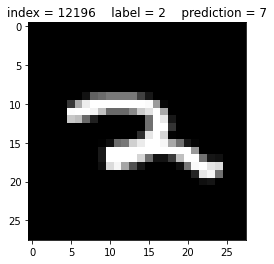

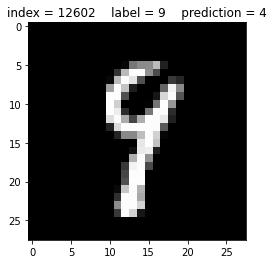

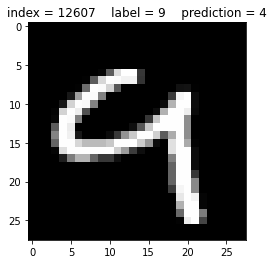

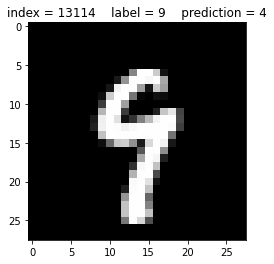

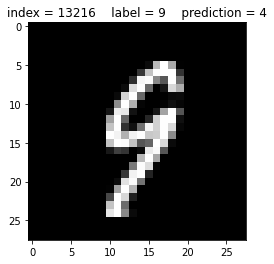

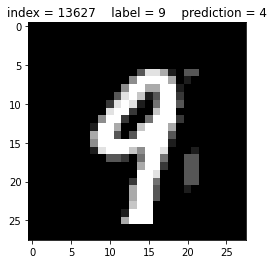

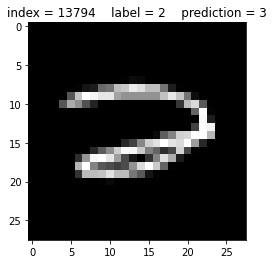

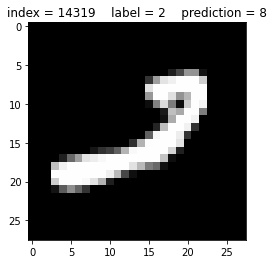

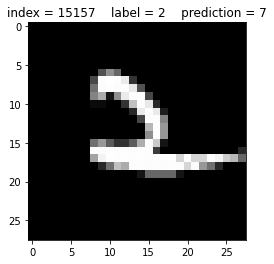

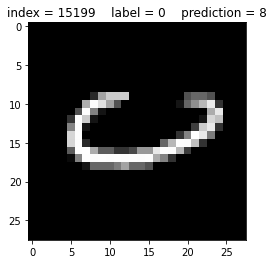

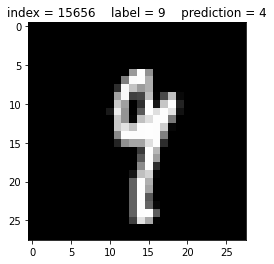

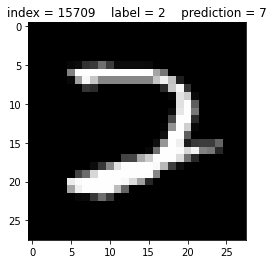

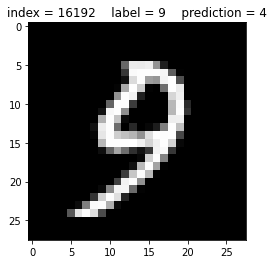

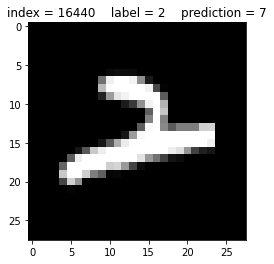

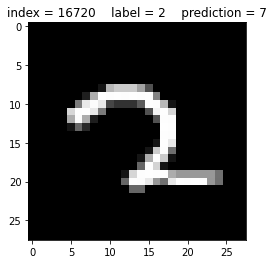

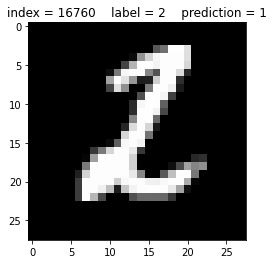

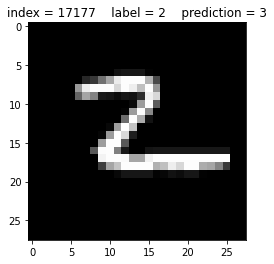

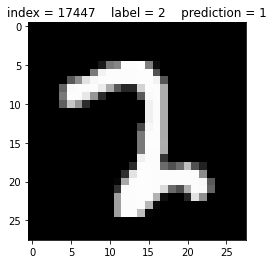

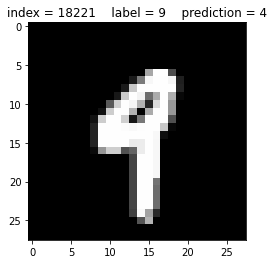

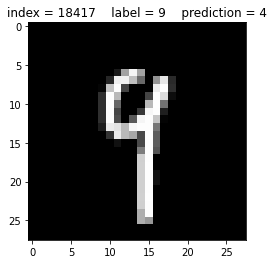

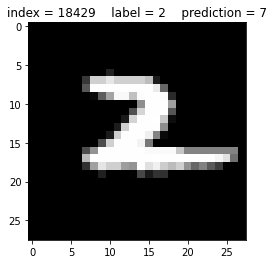

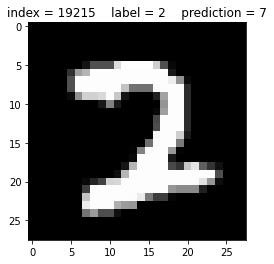

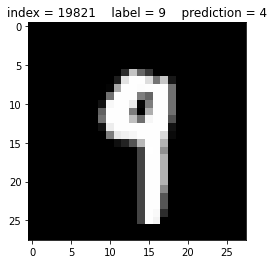

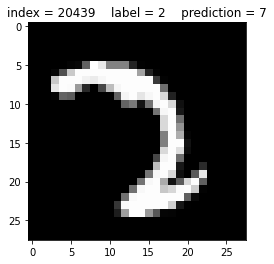

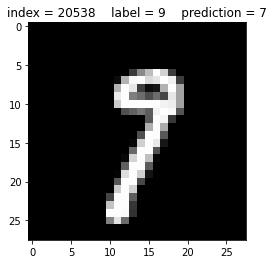

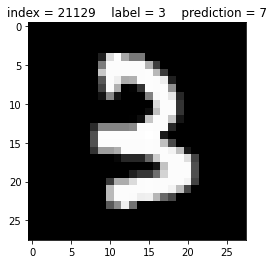

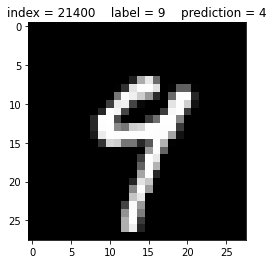

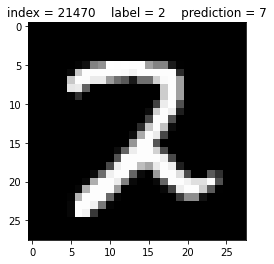

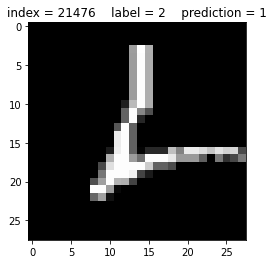

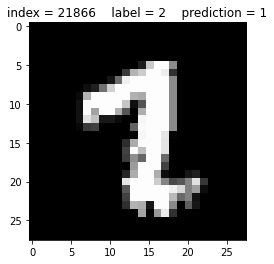

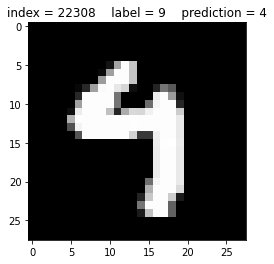

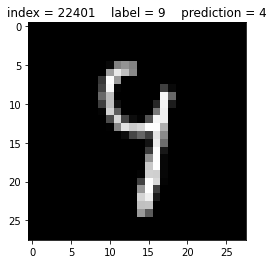

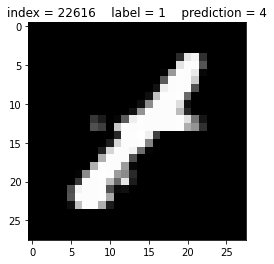

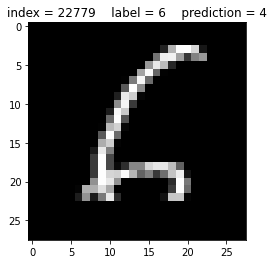

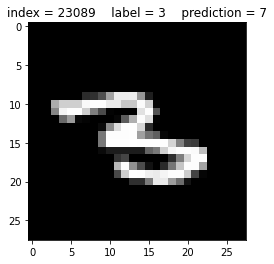

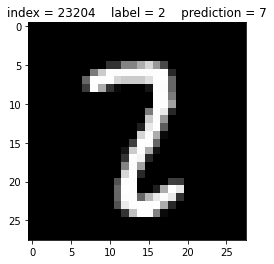

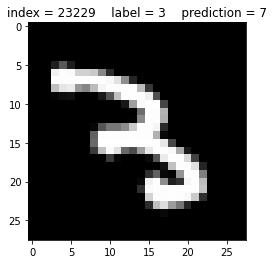

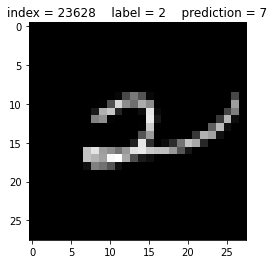

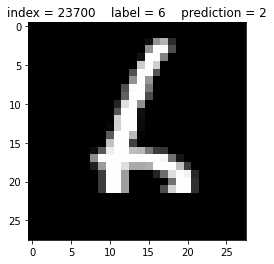

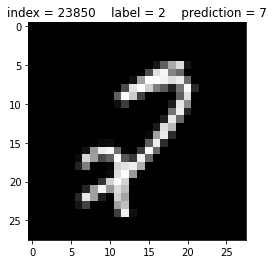

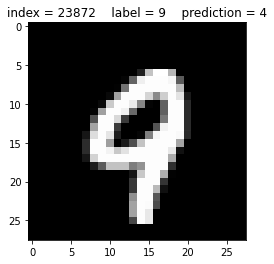

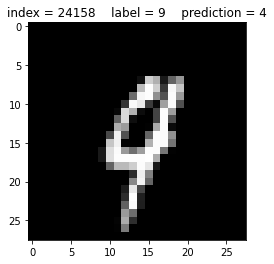

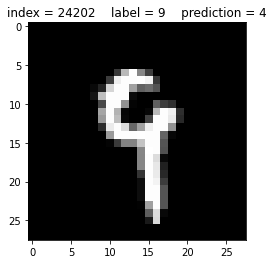

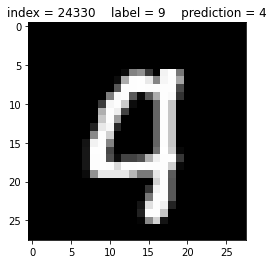

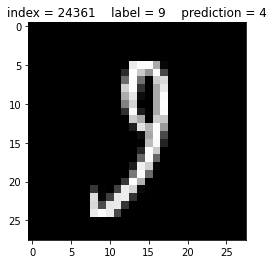

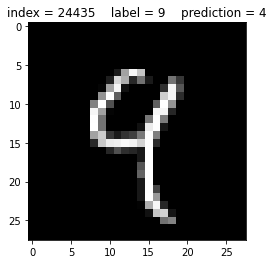

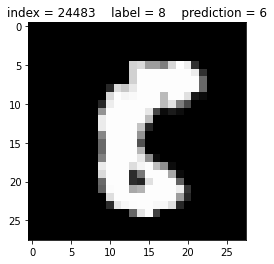

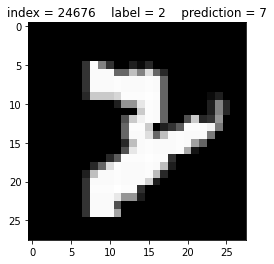

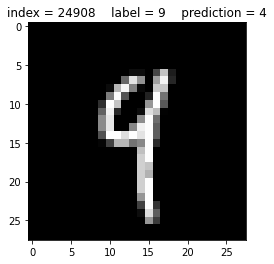

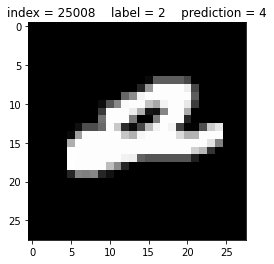

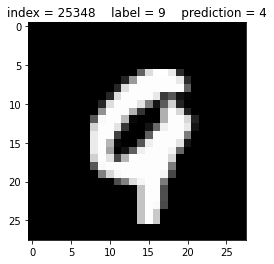

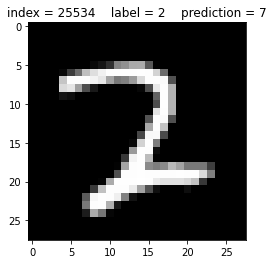

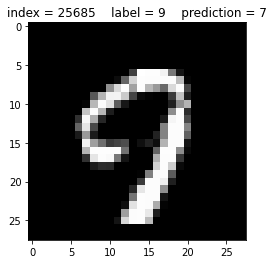

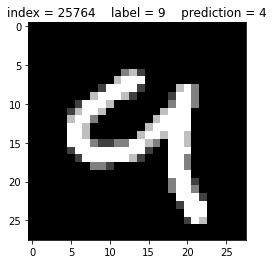

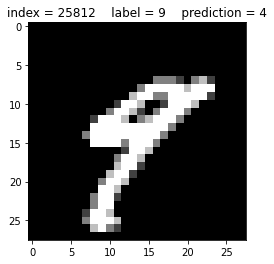

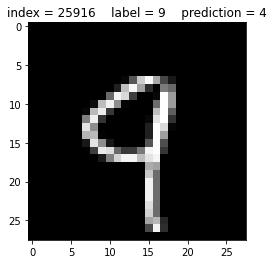

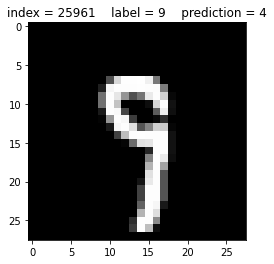

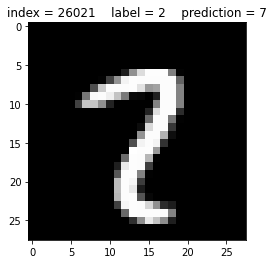

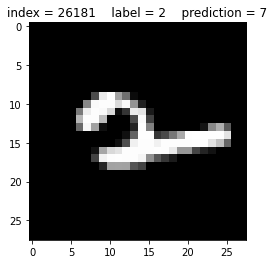

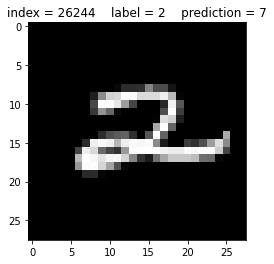

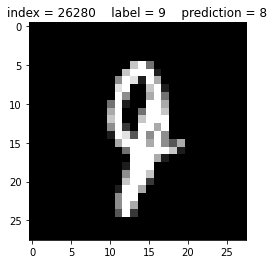

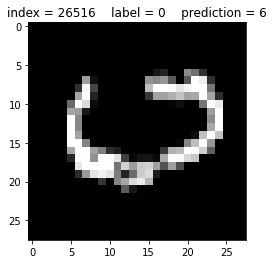

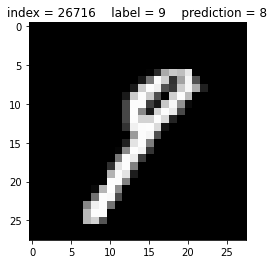

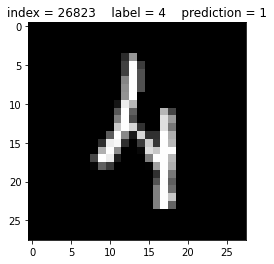

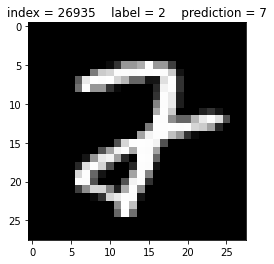

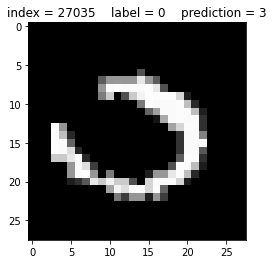

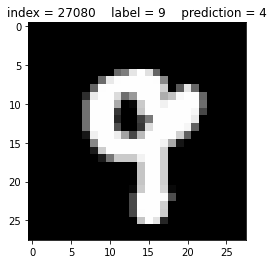

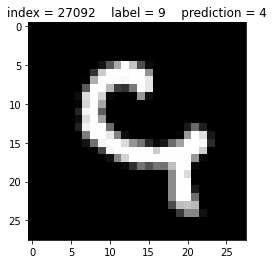

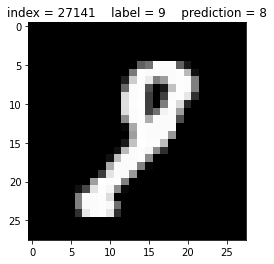

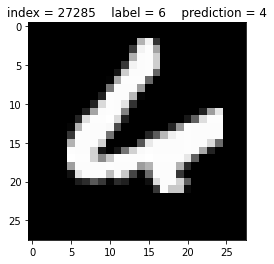

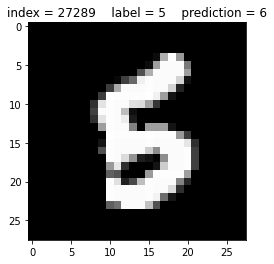

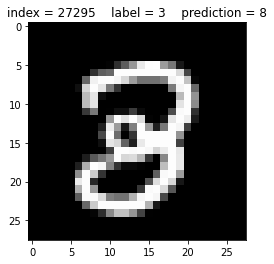

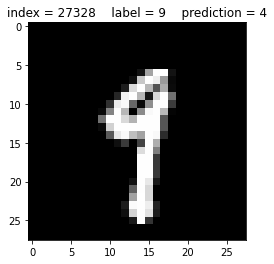

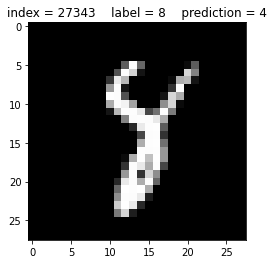

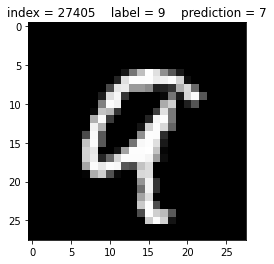

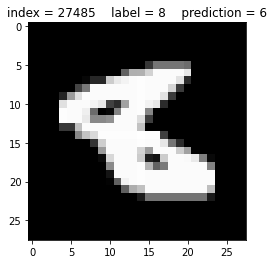

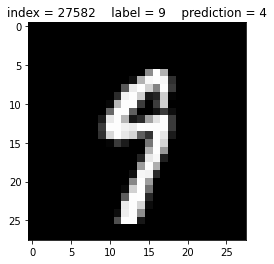

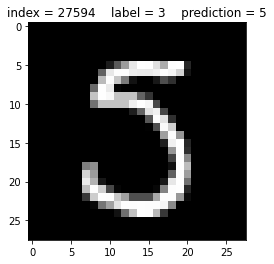

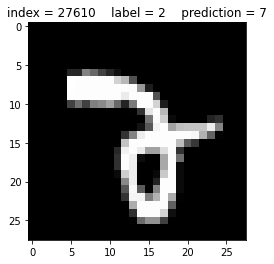

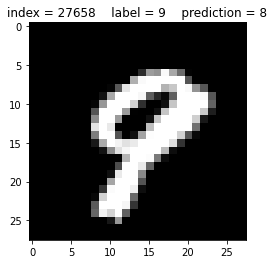

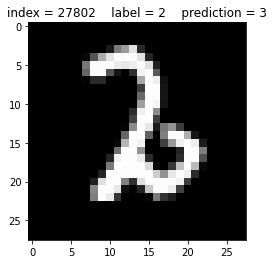

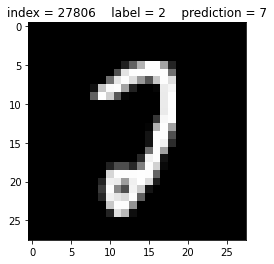

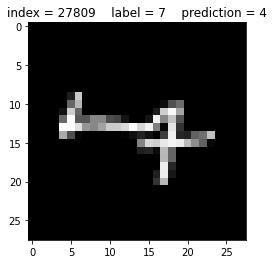

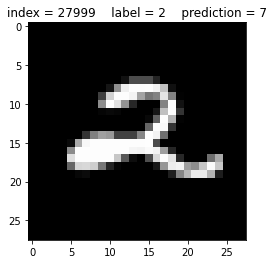

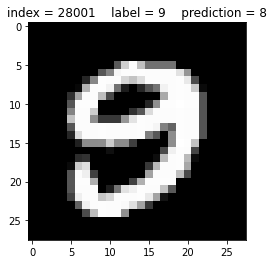

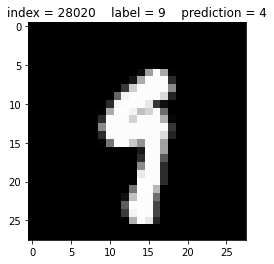

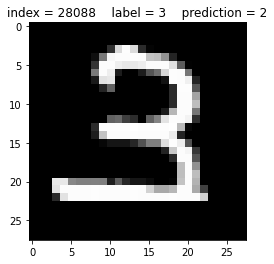

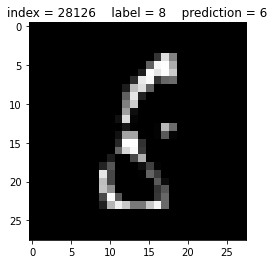

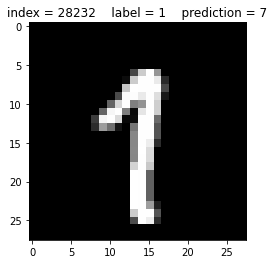

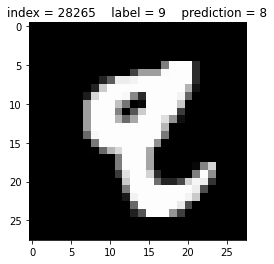

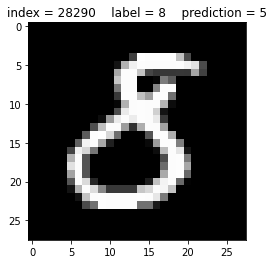

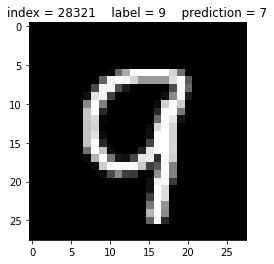

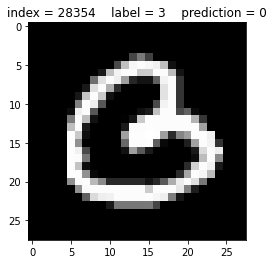

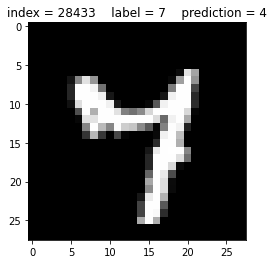

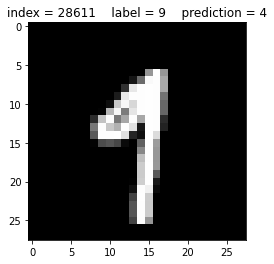

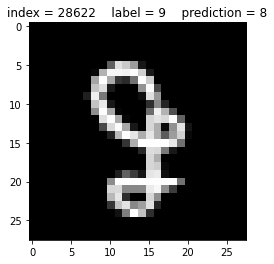

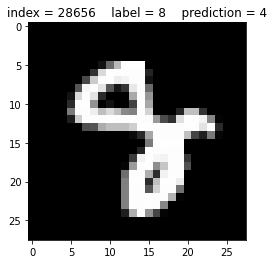

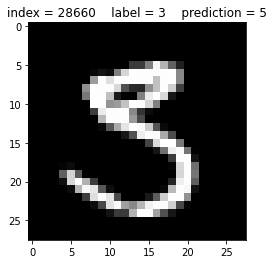

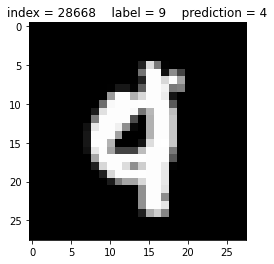

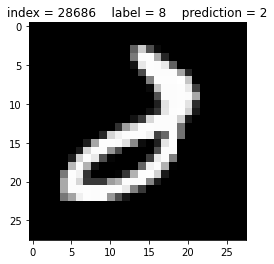

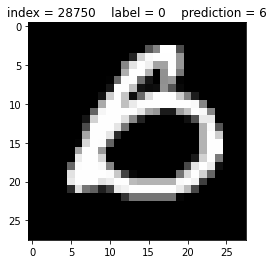

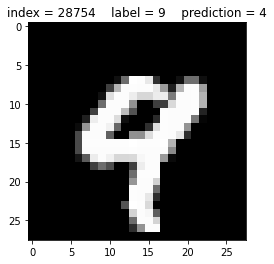

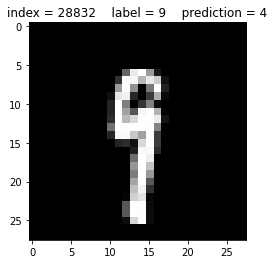

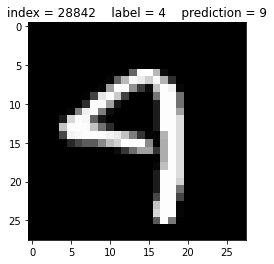

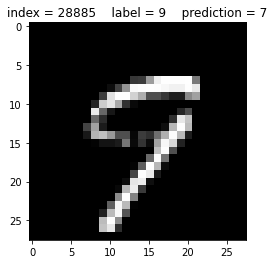

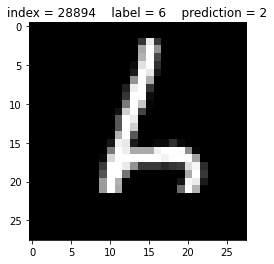

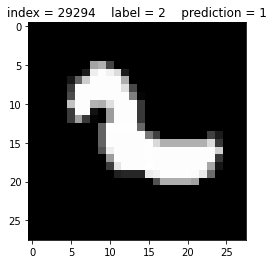

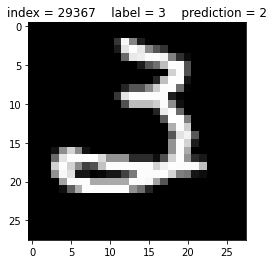

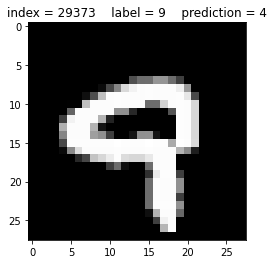

In [25]:
print("len(index_label_prediction_list) = ", len(index_label_prediction_list))
print()

start_index = int(input("start index : "))
count = int(input("count : "))
end_index = start_index + count

for self_pick_index in range(start_index, end_index):

    false_data_index = index_label_prediction_list[self_pick_index][0]
    false_data_label = index_label_prediction_list[self_pick_index][1]
    false_data_prediction = index_label_prediction_list[self_pick_index][2]

    img = train_train_xdata[false_data_index].reshape(28, 28)

    title = 'index = ' + str(false_data_index) + '    ' + 'label = ' + str(false_data_label) + '    ' + 'prediction = ' + str(false_data_prediction)

    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

In [26]:
'''
contaminated_data_set = {258, 1063, 1413, 1649, 1658, 1994, 5774, 20145, 20280, 20693, 24689, 25460, 26630, 
                         27137, 27206, 27211, 27230, 28168, 28274, 28380, 28997, 
                         29258, 8078, 9460, 9895, 18915, 9931, 26583, 8629, 25352,
                         17046, 10235, 19869, 17637, 9375}
'''

'\ncontaminated_data_set = {1649, 5774, 20145, 20280, 20693, 24689, 25460, 26630, \n                         27137, 27206, 27211, 27230, 28168, 28274, 28380, 28997, \n                         29258, 8078, 9460, 9895, 18915, 9931, 26583, 8629, 25352, \n                         17046, 10235, 19869, 17637, 9375}\n'

In [27]:
predicted_num = model.predict(test_data.reshape(-1, 28, 28, 1))

result = np.argmax(predicted_num, axis=1)

model_submission = get_dataframe(result)

model_submission.to_csv('digit_submission.csv', index=False)